Histopathologic Cancer Detection: https://www.kaggle.com/competitions/histopathologic-cancer-detection/data

Binary classification: 1 = cancer, 0 = no cancer

In [89]:
import os 
import pandas as pd
import numpy as np
import tifffile as tiff
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt 
import random

from PIL import Image 
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc 
from tensorflow.keras.metrics import AUC
from sklearn.metrics import precision_recall_curve

In [90]:
train_df = pd.read_csv("../train_labels.csv")
train_df.head(5)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [91]:
test_df = os.listdir("../test") 
test_df = pd.DataFrame({"id": test_df})
print(test_df.head(5))

                                             id
0  00006537328c33e284c973d7b39d340809f7271b.tif
1  0000ec92553fda4ce39889f9226ace43cae3364e.tif
2  00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif
3  000253dfaa0be9d0d100283b22284ab2f6b643f6.tif
4  000270442cc15af719583a8172c87cd2bd9c7746.tif


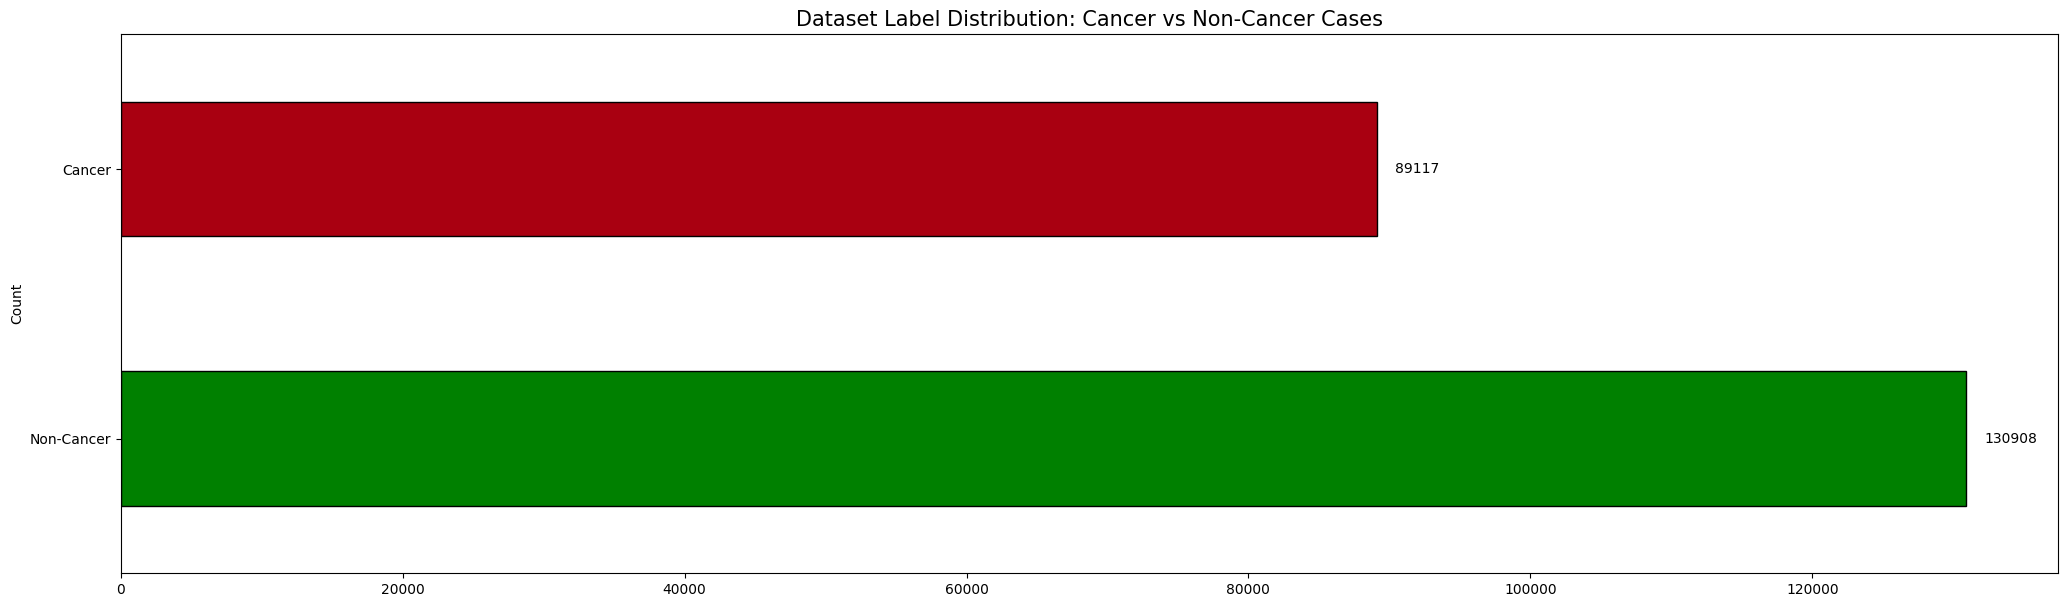

In [92]:
#unbalanced labels
#https://stackoverflow.com/questions/74075775/how-do-i-modify-the-the-bar-label-on-a-single-bar-in-matplotlib-barh
train_df.label.value_counts().rename({0: 'Non-Cancer', 1: 'Cancer'}).plot(kind='barh', color=['green', '#A90011'], edgecolor='black', figsize=(25,7)) 
plt.xticks(rotation=0)
plt.title('Dataset Label Distribution: Cancer vs Non-Cancer Cases', fontsize=15)
plt.ylabel('Count')
plt.bar_label(plt.gca().containers[0], padding=13, size=10)
plt.show()

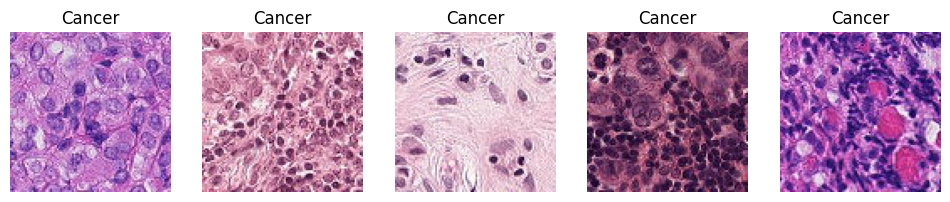

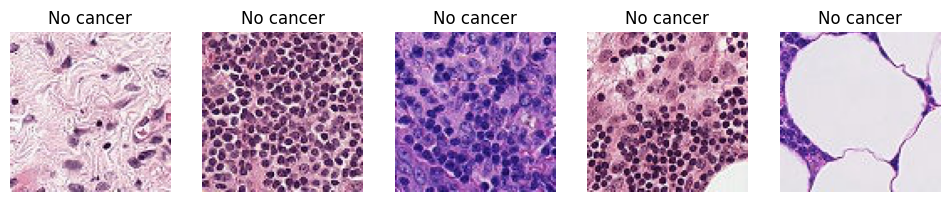

In [93]:
#https://stackoverflow.com/questions/19471814/display-multiple-images-in-one-ipython-notebook-cell
# zip: https://www.geeksforgeeks.org/python/python-iterate-multiple-lists-simultaneously/

fig, axes = plt.subplots(1,5, figsize=(12,5))

#5 images w/ cancer 
for ax, img_id in zip(axes, train_df[train_df.label == 1].sample(5).id): 
    ax.imshow(tiff.imread(f'../train/{img_id}.tif'))
    ax.axis('off')
    ax.set_title("Cancer")
plt.show()

fig, axes = plt.subplots(1,5, figsize=(12,5))

#5 images without cancer 
for ax, img_id in zip(axes, train_df[train_df.label == 0].sample(5).id): 
    ax.imshow(tiff.imread(f'../train/{img_id}.tif'))
    ax.axis('off')
    ax.set_title("No cancer")
plt.show()

In [94]:
#20000 images subset from df_train
cancer = train_df[train_df['label'] == 1].sample(10000, random_state=42)
nocancer = train_df[train_df['label'] == 0].sample(10000, random_state=42)

train_df_10000 = pd.concat([cancer, nocancer]).sample(frac=1, random_state=42).reset_index(drop=True) #frac1: shuffel & new clean index

train_df_10000["id"] = train_df_10000["id"] + ".tif"

In [95]:
#Validationset 25% --> train_df_5000
train_df, val_df = train_test_split(train_df_10000, test_size=0.25, random_state=0)
val_df.head(5)

,id,label
19134,351b2d6eb2aeaa22ac703075cbd3679186694ee7.tif,1
4981,22a1a7a1039e0e4f4e4e16b573e4d8ee6a7afa24.tif,1
16643,7a18fca002a4e372679c3dbb27d1b57521662252.tif,1
19117,efb17bd932a57195facb219999c28f2c1f4bdf63.tif,1
5306,37a25127f048621647a8b501f848750a9af5f21d.tif,1


In [96]:
#Kilde: Forelesning201025 del 2 / 04-CNN-hund-katt.ipynb 
#Kilde: https://www.kaggle.com/code/dmitrypukhov/cnn-with-imagedatagenerator-flow-from-dataframe
#CCN - Convolutional Neural Networks

#img prep - img gen
img_data = ImageDataGenerator(rescale=1/255., zoom_range=0.2, horizontal_flip=True, fill_mode='nearest', width_shift_range=0.1, height_shift_range=0.1,
    brightness_range=[0.8, 1.2]) #normalizing imgs before sending them to the model

#flow_from_dataframe = connects imgs & labels rather than manual X,y split. This is a more robust pipeline. 
train = img_data.flow_from_dataframe(
    dataframe=train_df, #id & label
    directory="../train", #img folder
    x_col="id", #id
    y_col="label", #0 or 1
    target_size = (96, 96),
    color_mode= "rgb",
    class_mode='raw',
    batch_size=64,
    shuffle=True,
    seed=42
)


Found 15000 validated image filenames.


In [97]:
#img prep - val gen

img_gen = ImageDataGenerator(rescale=1/255.)

validation = img_gen.flow_from_dataframe(
    dataframe=val_df, #id & label
    directory="../train", #img folder
    x_col="id", #id
    y_col="label", #0 or 1
    target_size = (96, 96), 
    class_mode='raw',
    color_mode= "rgb",
    batch_size=64,
    shuffle=False, #IMPORTANT!!! otherwise cm shows wrong values :'(
)

Found 5000 validated image filenames.


In [98]:
#test
#img prep

test = img_gen.flow_from_dataframe(
    dataframe=test_df,
    directory="../test",
    x_col="id",
    y_col=None,
    class_mode=None,
    target_size=(96, 96),
    color_mode= "rgb",
    batch_size=64,
    shuffle=False,
)

Found 57458 validated image filenames.


In [99]:
#print(auc)

In [100]:
#Kilde: https://keras.io/keras_tuner/  &  https://keras.io/keras_tuner/getting_started/
#https://medium.com/@piyushkashyap045/mastering-hyperparameter-tuning-for-neural-networks-with-keras-tuner-c0b64d549188

#model w/ hyperparameters

def build_model(hp):
    
    model = tf.keras.Sequential()

    #input
    model.add(tf.keras.Input(shape=(96, 96, 3)))

    #1st layer
    hp_filters = hp.Choice('filters', values=[16, 32, 64, 96])
    model.add(tf.keras.layers.Conv2D(hp_filters, (3,3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(2,2)) #maxpooling reduces noise

    #2nd layer
    model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(2,2))

    #flatten
    model.add(tf.keras.layers.Flatten())

    #number of neurons tuning
    hp_units = hp.Choice('dense_units', values=[32, 64, 96]) #128 was removed due to overfitting!
    model.add(tf.keras.layers.Dense(64, activation='relu')) #dense decides 0 or 1

    model.add(tf.keras.layers.Dense(1, activation='sigmoid')) #sigmoid: 0 or 1

    #learning rate
    hp_lr = hp.Choice('learning_rate', values=[1e-4, 1e-3, 1e-2])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr), # <-- gpt used due to syntax errors!
                  loss='binary_crossentropy', metrics=['accuracy', AUC(name='auc')])

    return model
    
#model.summary()

In [101]:
#creating the tuner 
#change project name for the keras tuner! otherwise it stores the old values
#test_1 results are stored down below
#test_2 results are stored 
#test_2_v2 w/ 20 epoch + auc (LATEST version)
tuner = kt.Hyperband(build_model, objective=kt.Objective('val_auc', direction='max'), max_epochs=15, factor=3, directory='tuner_dir', project_name='test_2_v3') #each trail contains epochs 5

#run tuner
tuner.search(train, epochs=5, validation_data=validation)

Reloading Tuner from tuner_dir\test_2_v3\tuner0.json


In [102]:
#print best parameters
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print("Best parameters: ")
print(best_hyperparameters.values)

Best parameters: 
{'filters': 16, 'dense_units': 96, 'learning_rate': 0.001, 'tuner/epochs': 15, 'tuner/initial_epoch': 5, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0012'}


In [103]:
#best model is built using: {'filters': 64, 'dense_units': 128, 'learning_rate': 0.001}
best_model = tuner.hypermodel.build(best_hyperparameters) #storing best hyperparameters into best_model 
model_history = best_model.fit(train, epochs=20, validation_data=validation) #validation_data=validation shows models performance on unseen images
best_model.summary()

#accuracy = performance on training data 
#val_accuracy = performance on validation data which is unseen images

Epoch 1/20
235/235 [==============================] - 203s 820ms/step - loss: 0.5724 - accuracy: 0.7117 - auc: 0.7846 - val_loss: 0.6301 - val_accuracy: 0.7144 - val_auc: 0.8350
Epoch 2/20
235/235 [==============================] - 43s 185ms/step - loss: 0.4883 - accuracy: 0.7704 - auc: 0.8466 - val_loss: 0.5904 - val_accuracy: 0.7366 - val_auc: 0.8389
Epoch 3/20
235/235 [==============================] - 38s 161ms/step - loss: 0.4809 - accuracy: 0.7725 - auc: 0.8516 - val_loss: 0.5786 - val_accuracy: 0.7418 - val_auc: 0.8404
Epoch 4/20
235/235 [==============================] - 38s 162ms/step - loss: 0.4787 - accuracy: 0.7762 - auc: 0.8535 - val_loss: 0.6574 - val_accuracy: 0.7268 - val_auc: 0.8376
Epoch 5/20
235/235 [==============================] - 38s 162ms/step - loss: 0.4645 - accuracy: 0.7856 - auc: 0.8624 - val_loss: 0.6061 - val_accuracy: 0.7384 - val_auc: 0.8571
Epoch 6/20
235/235 [==============================] - 38s 161ms/step - loss: 0.4633 - accuracy: 0.7858 - auc: 0.86




✨RESULTS FOR TEST_1 - 10 epochs:

The 1st model was built with these best_hyperparameters: {'filters': 64, 'dense_units': 128, 'learning_rate': 0.001}

Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 59s 126ms/step - accuracy: 0.9723 - loss: 0.0875 - val_accuracy: 0.7458 - val_loss: 1.1909


Accuracy on seen data is 97%

val_accuracy on unseen data is 75%

This means the model is struggling on unseen data - overfitting




✨RESULTS FOR TEST_2 - 10 epochs: 

The 2nd model was built with these best_hyperparameters: {'filters': 32, 'dense_units': 32, 'learning_rate': 0.0001}

Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 66s 141ms/step - accuracy: 0.7973 - loss: 0.4430 - val_accuracy: 0.8002 - val_loss: 0.4415

Accuracy on seen data is 80%

val_accuracy on unseen data is 80%

Although the first model achieved 97% accuracy on the training set, its validation was only 75%. This indicated overfitting. After adjusting the hyperparameters the secound model achieved balanced performance (80% acc & 80% val acc). This means the model generalized much better and is therefor the best model for solving this project/task. 

✨RESULTS FOR test_2_v2 - UPDATED W/ AUC metric & 20 epochs: 

Used: best_hyperparameters: {'filters': 32, 'dense_units': 32, 'learning_rate': 0.0001}

Epoch 20/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 85s 361ms/step - accuracy: 0.7984 - auc: 0.8762 - loss: 0.4421 - val_accuracy: 0.7290 - val_auc: 0.8483 - val_loss: 0.6418

Over 20 epochs the model achieved:
Accuracy (80%) on seen data val_accuracy (76%) 
auc (88%) shows how well model separates cancer and non cancer cases

✨RESULTS FOR test_2_v3:

Epoch 20/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 53s 227ms/step - accuracy: 0.8148 - auc: 0.8942 - loss: 0.4105 - val_accuracy: 0.7928 - val_auc: 0.8893 - val_loss: 0.4475



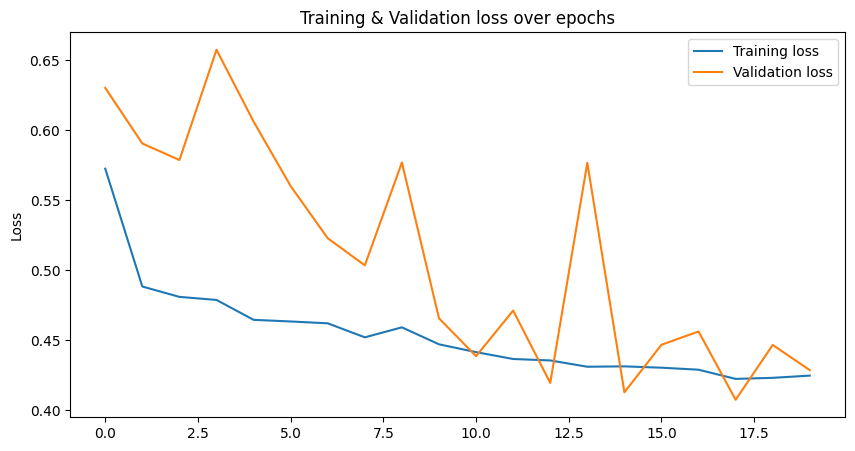

In [104]:
#train & val loss
plt.figure(figsize=(10,5))
plt.plot(model_history.history["loss"], label="Training loss")
plt.plot(model_history.history["val_loss"], label ="Validation loss")
plt.title("Training & Validation loss over epochs")
#plt.xlabel("Epoch") <--- error! 
plt.ylabel("Loss")
plt.legend()
plt.show()

The training loss decreases over the epochs, which shows that the model is learning effectively.
In constrast the validation loss does not show a clear downward trend. This could indicate that the model is sensitive to variations in the validation data. 
 

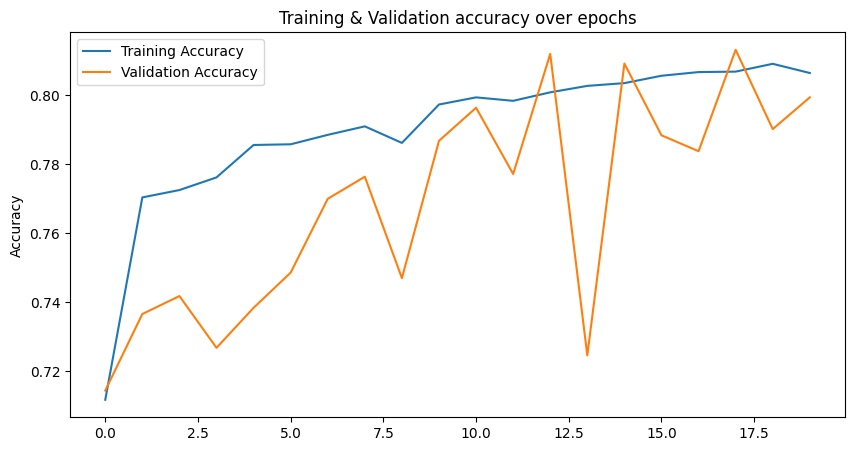

In [105]:
#train & val accuracy 
plt.figure(figsize=(10,5))
plt.plot(model_history.history["accuracy"], label="Training Accuracy")
plt.plot(model_history.history["val_accuracy"], label ="Validation Accuracy")
plt.title("Training & Validation accuracy over epochs")
#plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

The validation accuracy is quite noisy while the training accuracy inscreases steadily. Towards the end the validation accuracy shows a slight downward trend which indicates that the model is sensetive to unseen data and the model is learning patterns to new data. 

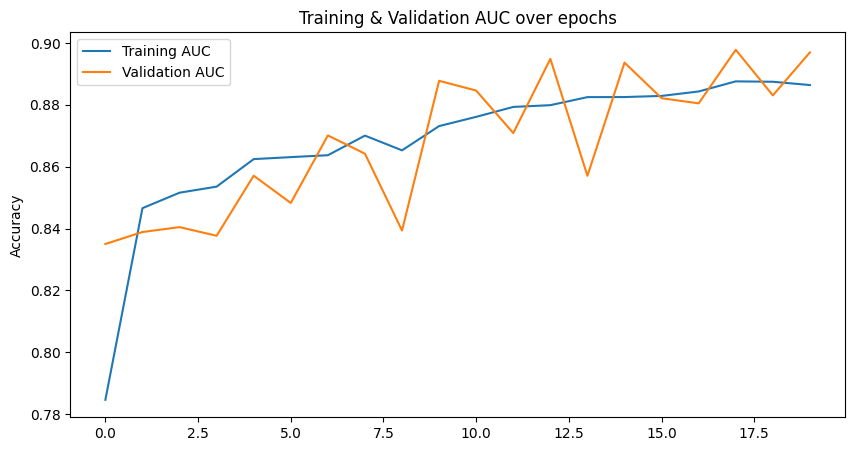

In [106]:
#auc & val_auc

#train & val accuracy 
plt.figure(figsize=(10,5))
plt.plot(model_history.history["auc"], label="Training AUC")
plt.plot(model_history.history["val_auc"], label ="Validation AUC")
plt.title("Training & Validation AUC over epochs")
#plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

The training AUC steadily increases across the epochs showing that the model becomes better. 
The validation AUC is more noisy but overall remains close to the training curve. 

In [108]:
#Crossvalidation
#gives the most reliable avg accuracy
#kidle: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
#kilde: https://www.geeksforgeeks.org/deep-learning/how-to-use-k-fold-cross-validation-in-a-neural-network/

#STRATISFIED KFOLD <----

stratified_k_fold = StratifiedKFold(n_splits=5, shuffle = True, random_state=42) 

#empty array to store cv scores 
fold_acc_scores = []
fold_auc_scores = [] 

for train_index, val_index in stratified_k_fold.split(train_df_10000, train_df_10000["label"]):

    training_fold = train_df_10000.iloc[train_index] #iloc extracts the actual data - otherwise only indexes would be passed
    validation_fold = train_df_10000.iloc[val_index]

    model = tuner.hypermodel.build(best_hyperparameters) 

    model.fit(img_data.flow_from_dataframe(training_fold, directory="../train",  #same code from GEN <------!!!!!!!
                                           x_col="id", y_col="label", target_size=(96,96), class_mode='raw', batch_size=32),
                                            epochs=5, verbose=0) #imgs from map train

    
    loss, accuracy, val_auc = model.evaluate(
        img_data.flow_from_dataframe(validation_fold, directory="../train",
                                                          x_col="id", y_col="label", target_size=(96,96), class_mode='raw', batch_size=32), verbose=0)


    fold_acc_scores.append(accuracy)
    fold_auc_scores.append(val_auc)

    print("Accuracy for this fold:", accuracy)
    print("AUC for this fold:", val_auc)

print("\n Cross Validation Results: ") 
print("Avg accuracy:", sum(fold_acc_scores) / len(fold_acc_scores))
print("Avg auc:", sum(fold_auc_scores) / len(fold_auc_scores))

Found 16000 validated image filenames.
Found 4000 validated image filenames.
Accuracy for this fold: 0.8077499866485596
AUC for this fold: 0.8849146366119385
Found 16000 validated image filenames.
Found 4000 validated image filenames.
Accuracy for this fold: 0.7997499704360962
AUC for this fold: 0.8698491454124451
Found 16000 validated image filenames.
Found 4000 validated image filenames.
Accuracy for this fold: 0.8109999895095825
AUC for this fold: 0.8961204290390015
Found 16000 validated image filenames.
Found 4000 validated image filenames.
Accuracy for this fold: 0.7954999804496765
AUC for this fold: 0.8727490901947021
Found 16000 validated image filenames.
Found 4000 validated image filenames.
Accuracy for this fold: 0.7929999828338623
AUC for this fold: 0.8812734484672546

 Cross Validation Results: 
Avg accuracy: 0.8013999819755554
Avg auc: 0.8809813499450684


Resultatet viser at modellen er konsistent. 
AUC på 0.86 indikerer at modellen har god evne til å skille mellom positive og negative tilfeller som er viktig for riktig diagnostikk.

79/79 [==============================] - 3s 36ms/step


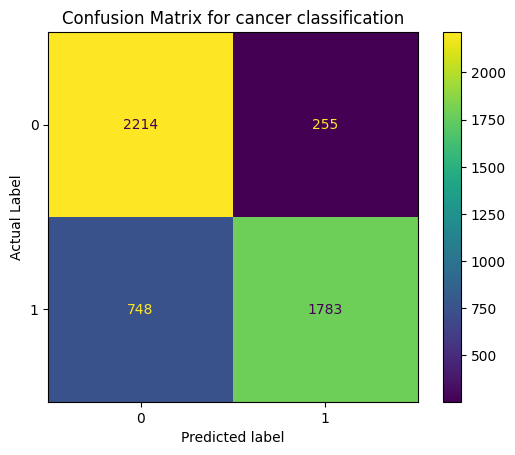

In [110]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html 
#confusion matrix 
#https://www.v7labs.com/blog/confusion-matrix-guide

validation_prob = best_model.predict(validation, verbose=1)

val_predictions = (validation_prob > 0.5).astype(int) #0.5 logic is due to sigmoid

true_labels = validation.labels

cm = confusion_matrix(true_labels, val_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="viridis")
plt.title("Confusion Matrix for cancer classification")
#plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

The model performs well but still misses a notable amount of cancer cases.  
1 364 were correctly identified as a cancer case & 1167 cancer cases were predicted wrong.
This is critical since missing a cancer cases is more serious than raising a false alarm. 
Overall the model is better at prediction non cancer cases than cancer cases. 

In [ ]:
#print(auc)

79/79 [==============================] - 3s 36ms/step


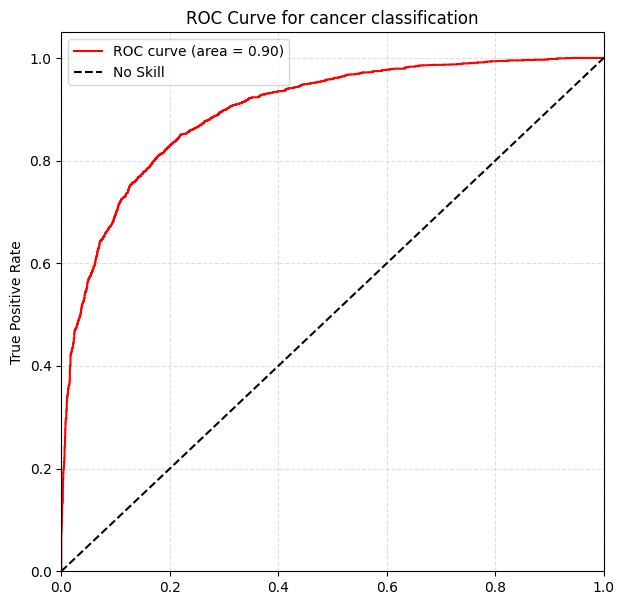

In [111]:
#ROC
#kilde: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
#kilde: https://www.geeksforgeeks.org/machine-learning/how-to-plot-roc-curve-in-python/

val_prob = best_model.predict(validation)
actual_lab = validation.labels.astype(int) 

fpr, tpr, thresholds = roc_curve(actual_lab, val_prob) 
roc_auc = auc(fpr, tpr) 

#plot
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, color='red', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
#labels
plt.title('ROC Curve for cancer classification')
#plt.xlabel('False Positive Rate') <-- error due to overwriting?
plt.ylabel('True Positive Rate')
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.show()

The models AUC score is 0.85 on the validation set which is good. This means the models makes correct decision 85% of the time. The red curve shows the model isnt guess randomly but there is still room to improve how well the model detects cancer cases. 

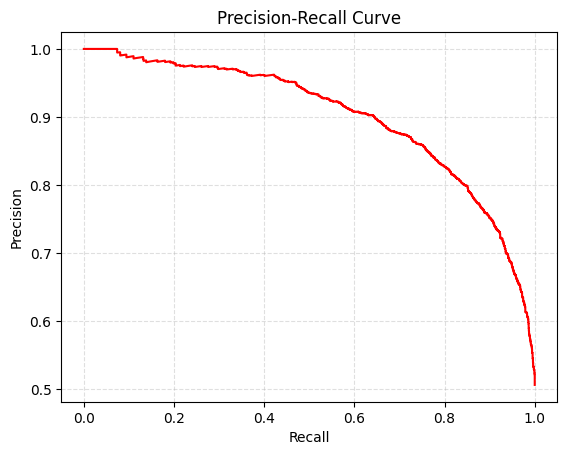

In [112]:
#Precision Recall curve = only for 1s
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
#https://www.statology.org/precision-recall-curve-python/


precision, recall, thresholds = precision_recall_curve(actual_lab, val_prob)

fig, ax = plt.subplots()
ax.plot(recall, precision, color='red')

ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

In [113]:
#KERAS GRAD-CAM
#Kilde: https://eli5.readthedocs.io/en/stable/tutorials/keras-image-classifiers.html
#Kilde: https://keras.io/examples/vision/grad_cam/

In [114]:
#https://stackoverflow.com/questions/68259714/get-the-output-of-the-last-convolutional-layer-of-a-pre-trained-architecture-in
#getting the name for the last convolusional layer for the gradcam
import keras

last_conv_layer_name = list(filter(lambda x: isinstance(x, keras.layers.Conv2D),best_model.layers))[-1].name

print(last_conv_layer_name)

conv2d_1


In [115]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        9280      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 30976)             0         
                                                                 
 dense (Dense)               (None, 64)                1

In [116]:
from IPython.display import Image, display
import matplotlib as mpl

In [117]:
#kilder
#https://keras.io/examples/vision/grad_cam/
#https://github.com/Bsingstad/Data-Mining-and-Analytics-2025/blob/main/Forelesning201025%20del%202/04%20CNN-hund-katt.ipynb

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [118]:
#kilder
#https://keras.io/examples/vision/grad_cam/
#https://github.com/Bsingstad/Data-Mining-and-Analytics-2025/blob/main/Forelesning201025%20del%202/04%20CNN-hund-katt.ipynb

from IPython.display import Image, display
import matplotlib as mpl
def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.8):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)
    
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)
    plt.imshow(superimposed_img)

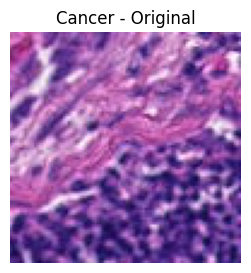

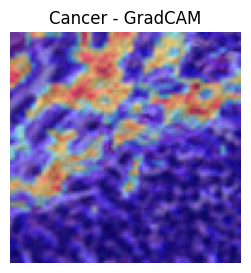

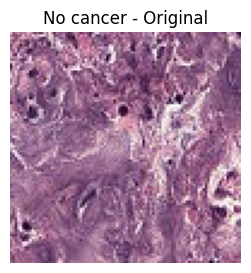

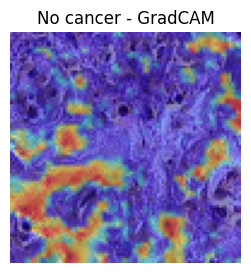

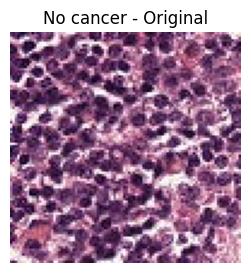

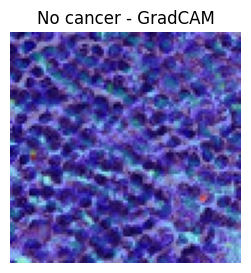

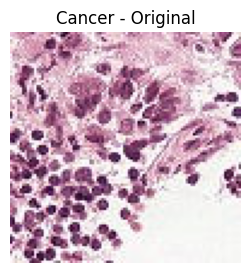

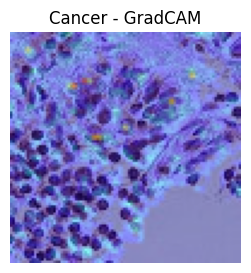

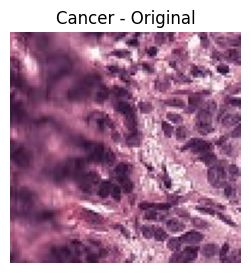

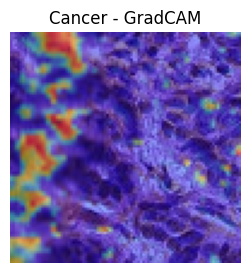

In [119]:
#kilder:
#https://github.com/Bsingstad/Data-Mining-and-Analytics-2025/blob/main/Forelesning201025%20del%202/04%20CNN-hund-katt.ipynb
#https://keras.io/examples/vision/grad_cam/
#
index = 10

for img_indx in range(index,index+5):
    #using img_indx to go through the indexes from the validation  
    
    img_path = "../train/" + val_df['id'].iloc[img_indx]
    
    img_id = val_df['label'].iloc[img_indx]

    #loading in the raw pictures from the string refrence in path
    #then making it compatible with heat_map by turning it into a multi dimentional array
    #used GPT 5.1 to understand and implement these 3 lines below of parsing the path refrence 
    #from the val_df datframe into raw image data and then into a multi dimentional array 
    img = tf.keras.utils.load_img(img_path, target_size=(96,96))
    img_array = tf.keras.utils.img_to_array(img)
    #used GPT 5.1 to understand an issue were the gradcam wasnt working. the fix was to add the missing normalization below
    img_array = img_array / 255.0 
    img_array = np.expand_dims(img_array, axis=0) 

    #after getting all the proper data: the image array, the tuned hypermodel and the last convolutional layer are added
    heat_map = make_gradcam_heatmap(img_array, best_model, last_conv_layer_name, pred_index=None)
    
    categories = ["No cancer", "Cancer"]
    plt.figure(figsize=(4,3))
    plt.imshow( tf.keras.utils.array_to_img(img))
    plt.title(f"{categories[img_id]} - Original")
    plt.axis("off")
    
    plt.figure(figsize=(4,3))
    save_and_display_gradcam(img_path,heat_map)
    plt.title(f"{categories[img_id]} - GradCAM")
    plt.axis("off")
    plt.show()

In [120]:
img_path = "..train/" + val_df['id'].iloc[2]
print(img_path)

..train/7a18fca002a4e372679c3dbb27d1b57521662252.tif


In [121]:
data_dir = "../"

train_ds = os.path.join(data_dir, "train")

In [122]:
#test pred

test_prediction = model.predict(test, verbose=1) 

#print(test_labels[:10]) #not the format we need for kaggle!

898/898 [==============================] - 361s 402ms/step


In [123]:
#kaggle submission
#kilde: https://www.kaggle.com/discussions/general/67397 - structure (input id & label)
#https://www.kaggle.com/competitions/histopathologic-cancer-detection/data - No .tif and 1d array format 
kaggle_submission = pd.DataFrame({"id": test_df["id"].str.replace(".tif", ""), #.tif
                                  "label": test_prediction.flatten()}) #flatten turns the labels into 1d array

kaggle_submission.to_csv("submission_model_1.csv", index=False)

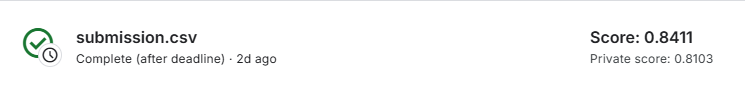